# Xenium experimental sample analysis (SpatialData + scverse)

This notebook mirrors the 10x Xenium 5k Python analysis journey for your experimental sample located at:

`/Users/rohit/Desktop/prostate_cancer_xenium/data/output-XETG00171__0050702__Region_2__20250606__163112`

Reference workflow: https://colab.research.google.com/github/10XGenomics/analysis_guides/blob/main/Xenium_5k_data_analysis_journey_python.ipynb

The steps below use the SpatialData and scverse ecosystem to load, QC, normalize, cluster, and visualize the data.

In [26]:
import os
import numpy as np
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

from pathlib import Path
from spatialdata_io import xenium
import spatialdata_plot
import json

sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi=90, facecolor="white")

In [6]:
data_dir = Path(
    "/Users/rohit/Desktop/prostate_cancer/data/output-XETG00171__0050702__Region_2__20250606__163112"
).resolve()

if not data_dir.exists():
    raise FileNotFoundError(f"Data directory not found: {data_dir}")

data_dir

PosixPath('/Users/rohit/Desktop/prostate_cancer/data/output-XETG00171__0050702__Region_2__20250606__163112')

In [7]:
sdata = xenium(data_dir)

sdata

/var/folders/l3/jmyvjlhj7m9dc0lz1z73gyc40000gn/T/ipykernel_2737/2348693635.py:1: DeprecationWarning: The default value of `cells_as_circles` will change to `False` in the next release. Please pass `True` explicitly to maintain the current behavior.
  sdata = xenium(data_dir)
/Users/rohit/.local/share/uv/python/cpython-3.13.7-macos-aarch64-none/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


SpatialData object
├── Images
│     └── 'morphology_focus': DataTree[cyx] (4, 20579, 54008), (4, 10289, 27004), (4, 5144, 13502), (4, 2572, 6751), (4, 1286, 3375)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (20579, 54008), (10289, 27004), (5144, 13502), (2572, 6751), (1286, 3375)
│     └── 'nucleus_labels': DataTree[yx] (20579, 54008), (10289, 27004), (5144, 13502), (2572, 6751), (1286, 3375)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 13) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (159613, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (159613, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (158906, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (159613, 5001)
with coordinate systems:
    ▸ 'global', with elements:
        morphology_focus (Images), cell_labels (Labels), nucleus_labels (Labels), transcripts (Points), cell_boundaries (Shapes), cell_circles (Shapes), nucleus_boundaries (S

In [8]:
list(sdata.tables.keys()), list(sdata.shapes.keys()), list(sdata.images.keys())

(['table'],
 ['nucleus_boundaries', 'cell_boundaries', 'cell_circles'],
 ['morphology_focus'])

## 1. Transcript and cell plotting (Xenium)

This section mirrors the Xenium transcript and cell plotting functions, using `SpatialData` elements loaded above. It auto-detects the most likely keys for cells, nuclei, and transcripts and then plots them with `matplotlib`.

In [9]:
cell_key = "cell_boundaries" if "cell_boundaries" in sdata.shapes else list(sdata.shapes.keys())[0]
nucleus_key = "nucleus_boundaries" if "nucleus_boundaries" in sdata.shapes else None
transcripts_key = "transcripts" if "transcripts" in getattr(sdata, "points", {}) else None

cell_key, nucleus_key, transcripts_key

('cell_boundaries', 'nucleus_boundaries', 'transcripts')

In [10]:
fig, ax = plt.subplots(figsize=(30, 30), dpi=300)

sdata.shapes[cell_key].plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.2)
if nucleus_key is not None:
    sdata.shapes[nucleus_key].plot(ax=ax, facecolor="none", edgecolor="#1f77b4", linewidth=0.2)

ax.set_title("Cell and nucleus boundaries")
ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])

ax.invert_yaxis()

# Save to high-res file in Downloads folder so you can zoom in on cells/nuclei
downloads_path = os.path.expanduser('~/Downloads/xenium_cell_nucleus_boundaries.png')
fig.savefig(downloads_path, bbox_inches='tight', dpi=600)
print(f"Saved high-res figure to {downloads_path}")

# Close to avoid embedding large images in the notebook
plt.close(fig)

Saved high-res figure to /Users/rohit/Downloads/xenium_cell_nucleus_boundaries.png


In [11]:
if transcripts_key is None:
    print("No transcript points found in sdata.points")
else:
    # sdata.points[transcripts_key] should already be a DataFrame or Dask DataFrame
    tx_df = sdata.points[transcripts_key]

    # If Dask DataFrame, convert to Pandas for filtering and plotting
    if hasattr(tx_df, "compute"):
        tx_df = tx_df.compute()

    if "feature_name" not in tx_df.columns:
        raise ValueError("Expected 'feature_name' column in transcripts")

    genes_to_plot = ["TUBB", "CDH1"]
    if len(genes_to_plot) < 2:
        raise ValueError("Please provide at least two genes in genes_to_plot")

    # Filter + downsample for speed
    tx_plot = tx_df.loc[tx_df["feature_name"].isin(genes_to_plot), ["x", "y", "feature_name"]]
    max_points = 50_000
    if len(tx_plot) > max_points:
        tx_plot = tx_plot.sample(n=max_points, random_state=0)

    # Style to match the plot above: black cell boundaries, blue nuclei if present, transcripts colored by gene
    fig, ax = plt.subplots(figsize=(30, 30), dpi=300)

    # Plot cell and nucleus boundaries in the background
    sdata.shapes[cell_key].plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.2)
    if nucleus_key is not None:
        sdata.shapes[nucleus_key].plot(ax=ax, facecolor="none", edgecolor="#1f77b4", linewidth=0.2)

    # Plot transcripts - make dots smaller, but with high contrast dark color
    color_map = dict(zip(genes_to_plot, plt.cm.tab10.colors[: len(genes_to_plot)]))
    # Use smaller dot size, higher alpha = 1.0, black edge for maximum darkness/contrast
    colors = tx_plot["feature_name"].map(color_map)
    ax.scatter(
        tx_plot["x"],
        tx_plot["y"],
        s=2,  # smaller dot size
        alpha=1.0,  # fully opaque
        linewidths=0.3,
        edgecolor="black",
        c=colors,
        rasterized=True,
    )
    
    # Add gene labels at the median point of each gene for identifying on the plot
    for gene in genes_to_plot:
        gene_tx = tx_plot[tx_plot["feature_name"] == gene]
        if not gene_tx.empty:
            median_x = gene_tx["x"].median()
            median_y = gene_tx["y"].median()
            ax.text(
                median_x,
                median_y,
                gene,
                color=color_map[gene],
                fontsize=28,
                weight="bold",
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", boxstyle="round,pad=0.3"),
                ha="center",
                va="center",
            )

    # Final style matching the plot above
    ax.set_title("Transcripts (2+ genes) with Cell/Nucleus Boundaries", fontsize=34)
    ax.set_xlabel("X position", fontsize=24)
    ax.set_ylabel("Y position", fontsize=24)
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.invert_yaxis()

    # Save to high-res file in Downloads folder so you can zoom in
    downloads_path = os.path.expanduser(f'~/Downloads/xenium_cell_transcripts_{genes_to_plot}.png')
    fig.savefig(downloads_path, bbox_inches='tight', dpi=600)
    print(f"Saved high-res figure to {downloads_path}")

    # Make legend tiny and move it to the top right outside the axes so it does not overlap any cell/nucleus at all
    handles = [plt.Line2D([0], [0], marker="o", linestyle="", color=color_map[g], markeredgecolor="black", markeredgewidth=0.3, markersize=8) for g in genes_to_plot]
    legend = ax.legend(
        handles, 
        genes_to_plot, 
        markerscale=1,
        frameon=False,
        fontsize=20,
        loc='upper left', # Use a corner that avoids data (could also use 'center left' or bbox_to_anchor)
        bbox_to_anchor=(1.02, 1.0), # move legend just outside the plotting area
        title="Genes", 
        title_fontsize=24,
        borderaxespad=0.0,
    )
    plt.tight_layout(rect=[0, 0, 0.93, 1])  # leave room for legend outside the plot

    # Close to avoid embedding large images in the notebook
    plt.close(fig)

Saved high-res figure to /Users/rohit/Downloads/xenium_cell_transcripts_['TUBB', 'CDH1'].png


## 2. QC and filtering (Xenium)

In [12]:
adata = sdata["table"]
adata.layers["counts"] = adata.X.copy()

In [13]:
# Define desired cutoffs and their colors
cutoffs = [150, 200, 300]
cutoff_colors = ["crimson", "orange", "seagreen"]

# More granular histogram: focus on 0-2500 transcripts/cell in fine bins
fig, axs = plt.subplots(1, 2, figsize=(14, 4), gridspec_kw={"width_ratios": [2, 1]})

# Overview plot: full range
axs[0].hist(adata.obs["total_counts"], bins=60, color="black", alpha=0.8)
axs[0].set_xlabel("Transcripts per cell")
axs[0].set_ylabel("Number of cells")
axs[0].set_title("QC: transcripts per cell (full range)")

# Draw colored vlines & text for each cutoff
for i, (c, color) in enumerate(zip(cutoffs, cutoff_colors)):
    axs[0].axvline(c, color=color, linestyle="--", linewidth=2, alpha=0.8)
    axs[0].text(
        c,
        axs[0].get_ylim()[1] * (0.9 - 0.05*i),
        f"cutoff={c}",
        color=color,
        fontsize=14,
        ha="left",
        va="top",
        fontweight="bold",
        bbox=dict(facecolor="white", alpha=0.5, edgecolor="none", pad=0.2)
    )

# Granular view: zoom on 0-2500 with finer bins
zoom_max = 2500
counts_zoom = adata.obs["total_counts"][adata.obs["total_counts"] <= zoom_max]
axs[1].hist(counts_zoom, bins=50, color="dodgerblue", alpha=0.9)
axs[1].set_xlabel("Transcripts per cell\n(zoom 0-2500)")
axs[1].set_ylabel("Number of cells")
axs[1].set_title("Zoom: 0-2500 transcripts")
axs[1].set_xlim(0, zoom_max)
axs[1].set_yticks([])  # Hide redundant y axis

# Also plot vlines & text on the zoomed panel
for i, (c, color) in enumerate(zip(cutoffs, cutoff_colors)):
    if c <= zoom_max:
        axs[1].axvline(c, color=color, linestyle="--", linewidth=2, alpha=0.8)
        axs[1].text(
            c,
            axs[1].get_ylim()[1] * (0.92 - 0.07*i),
            f"cutoff={c}",
            color=color,
            fontsize=13,
            ha="left",
            va="top",
            fontweight="bold",
            bbox=dict(facecolor="white", alpha=0.5, edgecolor="none", pad=0.2)
        )

plt.tight_layout()

# Save to high-res file in Downloads folder so you can zoom in
downloads_path = os.path.expanduser('~/Downloads/xenium_transcripts_per_cell.png')
fig.savefig(downloads_path, bbox_inches='tight', dpi=600)
print(f"Saved high-res figure to {downloads_path}")

# Close to avoid embedding large images in the notebook
plt.close(fig)

Saved high-res figure to /Users/rohit/Downloads/xenium_transcripts_per_cell.png


In [14]:
thres = np.quantile(adata.obs["total_counts"], 0.99)
sc.pp.filter_cells(adata, min_counts=200)
sc.pp.filter_cells(adata, max_counts=thres)

# filter genes rarely expressed
sc.pp.filter_genes(adata, min_cells=100)

filtered out 51458 cells that have less than 200 counts
filtered out 1565 cells that have more than 2056.0 counts
filtered out 580 genes that are detected in less than 100 cells


In [15]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000)

extracting highly variable genes


In [16]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers["log_norm"] = adata.X.copy()

normalizing counts per cell
    finished (0:00:00)


In [17]:
sc.pp.scale(adata, zero_center=False, max_value=10)

... be careful when using `max_value` without `zero_center`.


## 3. Clustering & neighborhood identification

In [18]:
# PCA for dimension reduction further by UMAP for downstream analysis
sc.pp.pca(adata, n_comps=30)
sc.pp.neighbors(adata, metric="cosine")
# clustering with leiden. We use igraph here as it scales better. The resolution is a hyper-parameter. A higher resolution will output more clusters.
sc.tl.leiden(adata, flavor="igraph", n_iterations=-1, resolution=0.5)

computing PCA
    with n_comps=30
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 30


/Users/rohit/Desktop/prostate_cancer/analysis/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished (0:00:22)
running Leiden clustering
    finished (0:00:10)


In [19]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:50)


Saved high-res figure to /Users/rohit/Downloads/umap_leiden.png


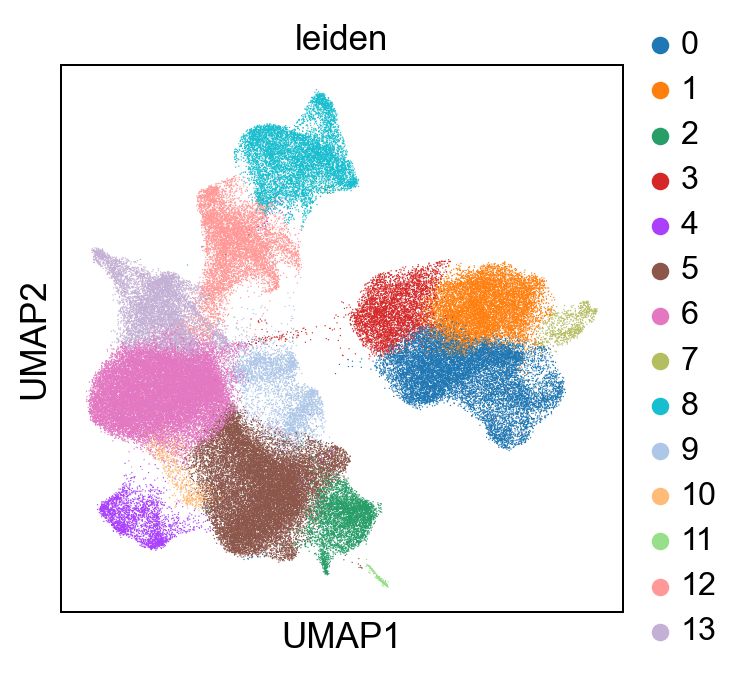

In [20]:
# Plot the UMAP and get the figure object
umap_fig = sc.pl.umap(adata, color='leiden', show=False, return_fig=True)

# Save to high-res file in Downloads folder so you can zoom in
downloads_path = os.path.expanduser('~/Downloads/umap_leiden.png')
umap_fig.savefig(downloads_path, bbox_inches='tight', dpi=600)
print(f"Saved high-res figure to {downloads_path}")

In [28]:
# 4. Dot plot of Leiden clusters on the tissue + export labels

# Get cell coordinates (prefer obsm['spatial'], fallback to common column names)
coords = None
if "spatial" in adata.obsm:
    coords = adata.obsm["spatial"]
    x = coords[:, 0]
    y = coords[:, 1]
else:
    possible = [
        ("x_centroid", "y_centroid"),
        ("center_x", "center_y"),
        ("x", "y"),
    ]
    for x_col, y_col in possible:
        if x_col in adata.obs.columns and y_col in adata.obs.columns:
            x = adata.obs[x_col].to_numpy()
            y = adata.obs[y_col].to_numpy()
            break
    else:
        raise ValueError("No spatial coordinates found in adata.obsm['spatial'] or known columns.")

# Color map for Leiden clusters (sorted ascending)
leiden = adata.obs["leiden"].astype(str)

def _sort_key(val: str):
    return (0, int(val)) if val.isdigit() else (1, val)

ordered_categories = sorted(pd.unique(leiden), key=_sort_key)
cluster_codes = pd.Categorical(leiden, categories=ordered_categories, ordered=True)

# "tab20" has 20 discrete colors; repeat if there are more clusters
cmap = mpl.colormaps.get_cmap("tab20")
colors = np.array([cmap(code % 20) for code in cluster_codes.codes])

# Load ChatGPT annotations (cluster -> cell type)
import json
annotations_path = "/Users/rohit/Desktop/prostate_cancer/analysis/chatgpt_celltype_annotations.json"
if os.path.exists(annotations_path):
    with open(annotations_path, "r") as f:
        annotations = json.load(f)
else:
    annotations = {}

fig, ax = plt.subplots(figsize=(20, 15), dpi=300)
ax.scatter(
    x,
    y,
    s=2,
    c=colors,
    alpha=0.9,
    linewidths=0,
    rasterized=True,
)

# Legend outside the plot for clarity (ascending order)
legend_handles = []
for i, cat in enumerate(cluster_codes.categories):
    cell_type = "unknown"
    if str(cat) in annotations and isinstance(annotations[str(cat)], dict):
        cell_type = annotations[str(cat)].get("annotation", "unknown") or "unknown"
    label = f"{cat}: {cell_type}"
    legend_handles.append(
        plt.Line2D(
            [0],
            [0],
            marker="o",
            linestyle="",
            markersize=6,
            markerfacecolor=cmap(i % 20),
            markeredgecolor="none",
            label=label,
        )
    )

ax.legend(
    handles=legend_handles,
    title="Cell type",
    frameon=False,
    fontsize=10,
    title_fontsize=12,
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
    borderaxespad=0.0,
)

ax.set_title("Cell type annotations (dot plot)", fontsize=24)
ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])
ax.invert_yaxis()
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Save high-res overlay to Downloads
downloads_path = os.path.expanduser("~/Downloads/xenium_celltype_overlay.png")
fig.savefig(downloads_path, bbox_inches="tight", dpi=600)
print(f"Saved cell type overlay to {downloads_path}")

# Close to avoid embedding large images in the notebook
plt.close(fig)

# Save cluster labels with explicit cell_id and group columns
cluster_df = adata.obs[["leiden"]].copy()
cluster_df = cluster_df.rename(columns={"leiden": "group"})

# Use the Xenium cell IDs stored in adata.obs["cell_id"]
cell_ids = adata.obs["cell_id"].astype(str)

cluster_df.insert(0, "cell_id", cell_ids)
cluster_df = cluster_df[["cell_id", "group"]]

csv_path = os.path.expanduser("~/Downloads/leiden_clusters.csv")
cluster_df.to_csv(csv_path, sep=",", index=False)
print(f"Saved Leiden clusters to {csv_path}")


Saved cell type overlay to /Users/rohit/Downloads/xenium_celltype_overlay.png
Saved Leiden clusters to /Users/rohit/Downloads/leiden_clusters.csv


## 4. Cell type annotation and differentially expressed genes

In [22]:
sc.tl.rank_genes_groups(adata, groupby="leiden", layer="log_norm", pts=True)

ranking genes
    finished (0:00:02)


Saved rank genes dotplot to /Users/rohit/Downloads/xenium_rank_genes_dotplot.png


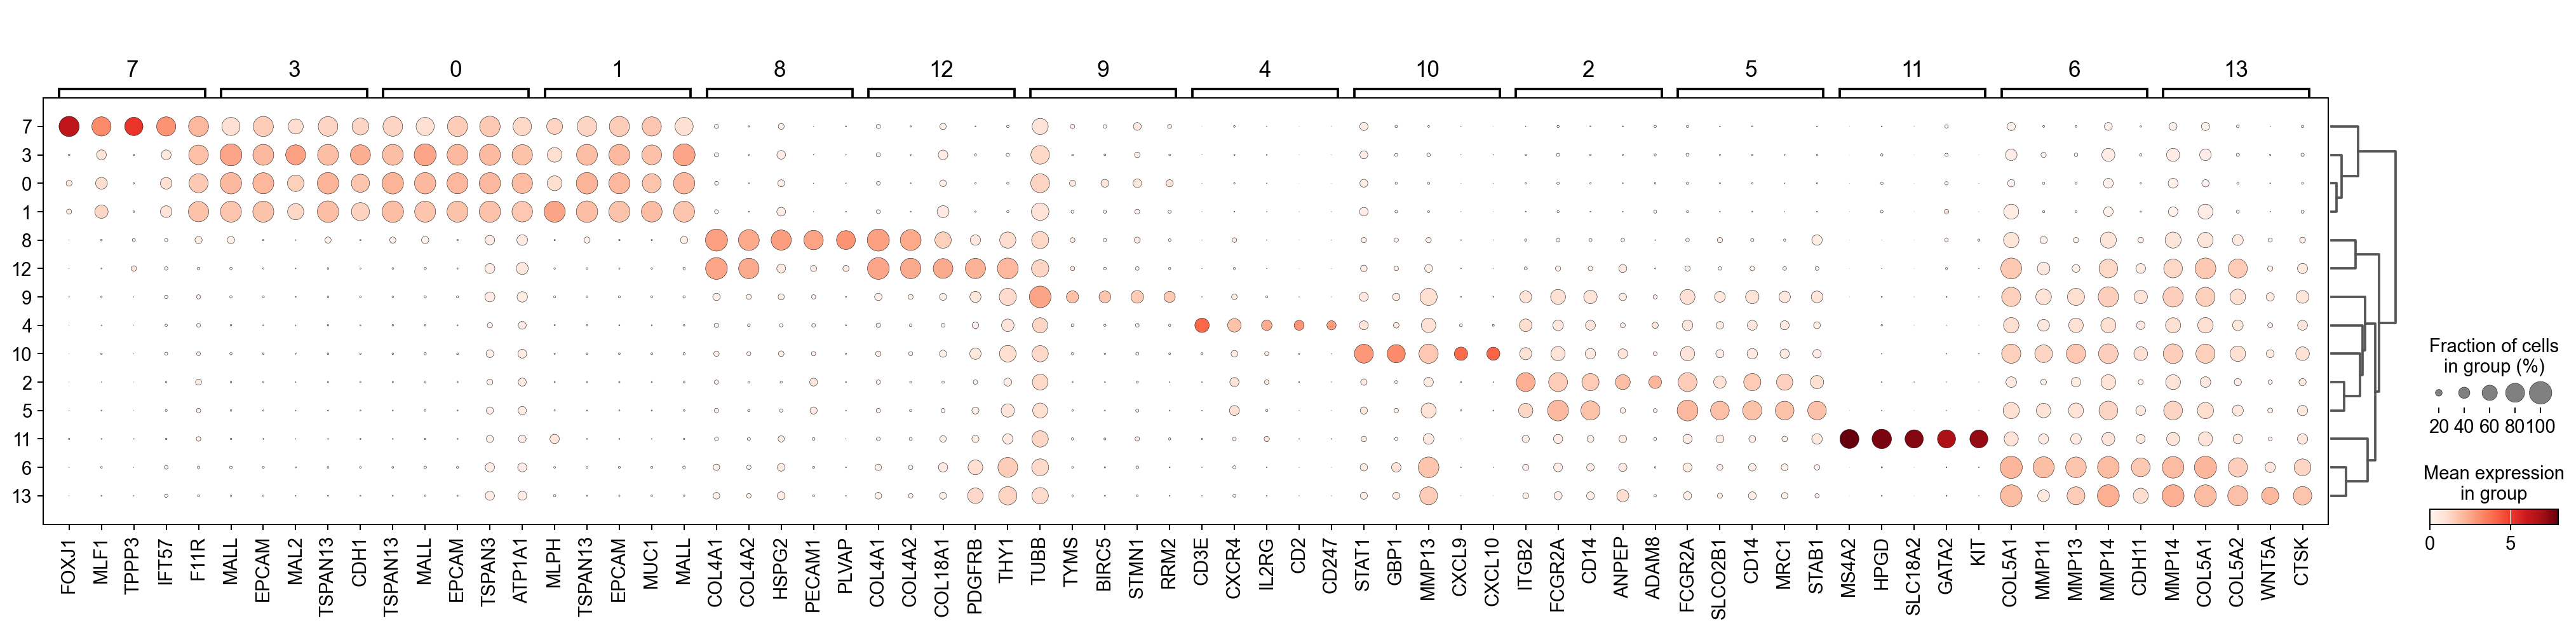

In [24]:
dotplot = sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, show=False, return_fig=True)

# Save to high-res file in Downloads folder
downloads_path = os.path.expanduser('~/Downloads/xenium_rank_genes_dotplot.png')
dotplot.savefig(downloads_path, bbox_inches='tight', dpi=600)
print(f"Saved rank genes dotplot to {downloads_path}")

In [27]:
# 5. Export enriched genes per cluster for ChatGPT annotation
output_dir = Path("/Users/rohit/Desktop/prostate_cancer/analysis")
output_dir.mkdir(parents=True, exist_ok=True)

genes_json_path = output_dir / "cluster_enriched_genes.json"
genes_tsv_path = output_dir / "cluster_enriched_genes.tsv"
prompt_path = output_dir / "chatgpt_celltype_prompt.txt"
chatgpt_output_path = output_dir / "chatgpt_celltype_annotations.json"

# Tweak these if you want more/less genes per cluster
# (filtering keeps only stronger, more reliable markers)
top_n = 30
min_logfc = 0.5
max_adj_pval = 0.05

clusters = adata.obs["leiden"].astype(str).unique().tolist()
if "_sort_key" in globals():
    clusters = sorted(clusters, key=_sort_key)
else:
    clusters = sorted(clusters)

gene_lists = {}
rows = []

for cluster in clusters:
    df = sc.get.rank_genes_groups_df(adata, group=cluster)
    df = df.dropna(subset=["names"])

    if "logfoldchanges" in df.columns:
        df = df[df["logfoldchanges"] >= min_logfc]
    if "pvals_adj" in df.columns:
        df = df[df["pvals_adj"] <= max_adj_pval]

    genes = df["names"].astype(str).head(top_n).tolist()
    if len(genes) == 0:
        # Fallback: unfiltered top_n if thresholds are too strict
        df_fallback = sc.get.rank_genes_groups_df(adata, group=cluster)
        genes = df_fallback["names"].astype(str).head(top_n).tolist()

    gene_lists[str(cluster)] = genes
    rows.append({"cluster": str(cluster), "genes": ", ".join(genes)})

# Save for easy copy/paste into ChatGPT
pd.DataFrame(rows).to_csv(genes_tsv_path, sep="\t", index=False)
with open(genes_json_path, "w") as f:
    json.dump(gene_lists, f, indent=2)

print(f"Saved enriched genes (JSON) to {genes_json_path}")
print(f"Saved enriched genes (TSV) to {genes_tsv_path}")

# Create a placeholder output file for ChatGPT annotations (won't overwrite)
if not chatgpt_output_path.exists():
    placeholder = {
        str(c): {"annotation": "", "markers_used": []}
        for c in clusters
    }
    with open(chatgpt_output_path, "w") as f:
        json.dump(placeholder, f, indent=2)
    print(f"Created placeholder annotations file at {chatgpt_output_path}")
else:
    print(f"Annotations file already exists at {chatgpt_output_path}")

# Reminder of the prompt file path to use with ChatGPT
print(f"Prompt file: {prompt_path}")

Saved enriched genes (JSON) to /Users/rohit/Desktop/prostate_cancer/analysis/cluster_enriched_genes.json
Saved enriched genes (TSV) to /Users/rohit/Desktop/prostate_cancer/analysis/cluster_enriched_genes.tsv
Created placeholder annotations file at /Users/rohit/Desktop/prostate_cancer/analysis/chatgpt_celltype_annotations.json
Prompt file: /Users/rohit/Desktop/prostate_cancer/analysis/chatgpt_celltype_prompt.txt


In [ ]:
# 6. Add cell-type labels from ChatGPT + plot spatial distributions
import json

annotations_path = Path("/Users/rohit/Desktop/prostate_cancer/analysis/chatgpt_celltype_annotations.json")
if not annotations_path.exists():
    raise FileNotFoundError(f"Missing annotations file: {annotations_path}")

with open(annotations_path, "r") as f:
    annotations = json.load(f)

# Map leiden -> cell type label
cluster_to_celltype = {
    str(k): (v.get("annotation") if isinstance(v, dict) else str(v))
    for k, v in annotations.items()
}

# Store in AnnData for downstream plotting
adata.obs["cell_type"] = adata.obs["leiden"].astype(str).map(cluster_to_celltype).fillna("unknown")
print("Added adata.obs['cell_type'] from chatgpt_celltype_annotations.json")


def plot_celltype_pair(
    adata,
    celltype_a,
    celltype_b,
    label_col="cell_type",
    match_mode="substring",  # 'substring' or 'exact'
    colors=("crimson", "steelblue"),
    point_size=2,
    alpha=0.9,
    out_path=None,
):
    """Plot spatial distribution of two cell types and save the figure."""
    # Get coordinates (prefer obsm['spatial'])
    if "spatial" in adata.obsm:
        coords = adata.obsm["spatial"]
        x = coords[:, 0]
        y = coords[:, 1]
    else:
        possible = [
            ("x_centroid", "y_centroid"),
            ("center_x", "center_y"),
            ("x", "y"),
        ]
        for x_col, y_col in possible:
            if x_col in adata.obs.columns and y_col in adata.obs.columns:
                x = adata.obs[x_col].to_numpy()
                y = adata.obs[y_col].to_numpy()
                break
        else:
            raise ValueError("No spatial coordinates found in adata.obsm['spatial'] or known columns.")

    labels = adata.obs[label_col].astype(str)
    if match_mode == "exact":
        mask_a = labels == celltype_a
        mask_b = labels == celltype_b
    else:
        mask_a = labels.str.contains(celltype_a, case=False, regex=False)
        mask_b = labels.str.contains(celltype_b, case=False, regex=False)

    fig, ax = plt.subplots(figsize=(20, 15), dpi=300)
    ax.scatter(x[mask_a], y[mask_a], s=point_size, c=colors[0], alpha=alpha, linewidths=0, rasterized=True)
    ax.scatter(x[mask_b], y[mask_b], s=point_size, c=colors[1], alpha=alpha, linewidths=0, rasterized=True)

    ax.set_title(f"{celltype_a} vs {celltype_b}", fontsize=24)
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.invert_yaxis()

    legend_handles = [
        plt.Line2D([0], [0], marker="o", linestyle="", markersize=6, markerfacecolor=colors[0], label=celltype_a),
        plt.Line2D([0], [0], marker="o", linestyle="", markersize=6, markerfacecolor=colors[1], label=celltype_b),
    ]
    ax.legend(handles=legend_handles, frameon=False, fontsize=12, loc="upper left", bbox_to_anchor=(1.02, 1.0))
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    if out_path is None:
        safe_a = celltype_a.replace(" ", "_").lower()
        safe_b = celltype_b.replace(" ", "_").lower()
        out_path = os.path.expanduser(f"~/Downloads/xenium_{safe_a}_vs_{safe_b}.png")

    fig.savefig(out_path, bbox_inches="tight", dpi=600)
    print(f"Saved plot to {out_path}")
    plt.close(fig)


# Example: any macrophage vs any fibroblast (substring match)
plot_celltype_pair(adata, "macrophage", "fibroblast")

Added adata.obs['cell_type'] from chatgpt_celltype_annotations.json
Saved plot to /Users/rohit/Downloads/xenium_macrophage_vs_fibroblast.png


In [30]:
# 7. Save processed SpatialData (including AnnData) to Zarr
import shutil

zarr_path = Path("/Users/rohit/Downloads/xenium_processed_spatialdata.zarr")

# Ensure the updated AnnData (with cell_type labels) is stored back into SpatialData
sdata["table"] = adata

# Overwrite if it already exists
if zarr_path.exists():
    shutil.rmtree(zarr_path)

sdata.write(zarr_path)
print(f"Saved SpatialData to {zarr_path}")

/Users/rohit/Desktop/prostate_cancer/analysis/.venv/lib/python3.13/site-packages/pims/tiff_stack.py:131: UserWarning: <tifffile.TiffPage 0 @16> reading array from closed file
  data = t.asarray()
/Users/rohit/Desktop/prostate_cancer/analysis/.venv/lib/python3.13/site-packages/zarr/core/dtype/npy/structured.py:318: UnstableSpecificationWarning: The data type (Structured(fields=(('0', FixedLengthUTF32(length=9, endianness='little')), ('1', FixedLengthUTF32(length=9, endianness='little')), ('2', FixedLengthUTF32(length=9, endianness='little')), ('3', FixedLengthUTF32(length=9, endianness='little')), ('4', FixedLengthUTF32(length=9, endianness='little')), ('5', FixedLengthUTF32(length=9, endianness='little')), ('6', FixedLengthUTF32(length=9, endianness='little')), ('7', FixedLengthUTF32(length=9, endianness='little')), ('8', FixedLengthUTF32(length=9, endianness='little')), ('9', FixedLengthUTF32(length=9, endianness='little')), ('10', FixedLengthUTF32(length=9, endianness='little')), ('1

Saved SpatialData to /Users/rohit/Downloads/xenium_processed_spatialdata.zarr


/Users/rohit/Desktop/prostate_cancer/analysis/.venv/lib/python3.13/site-packages/zarr/core/dtype/npy/structured.py:318: UnstableSpecificationWarning: The data type (Structured(fields=(('0', Float32(endianness='little')), ('1', Float32(endianness='little')), ('2', Float32(endianness='little')), ('3', Float32(endianness='little')), ('4', Float32(endianness='little')), ('5', Float32(endianness='little')), ('6', Float32(endianness='little')), ('7', Float32(endianness='little')), ('8', Float32(endianness='little')), ('9', Float32(endianness='little')), ('10', Float32(endianness='little')), ('11', Float32(endianness='little')), ('12', Float32(endianness='little')), ('13', Float32(endianness='little'))))) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check